# Michael Nguyen

# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [22]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn as pyLDAvis_sklear

In [3]:
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [5]:
import pyLDAvis.sklearn

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [8]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [9]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [10]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [11]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

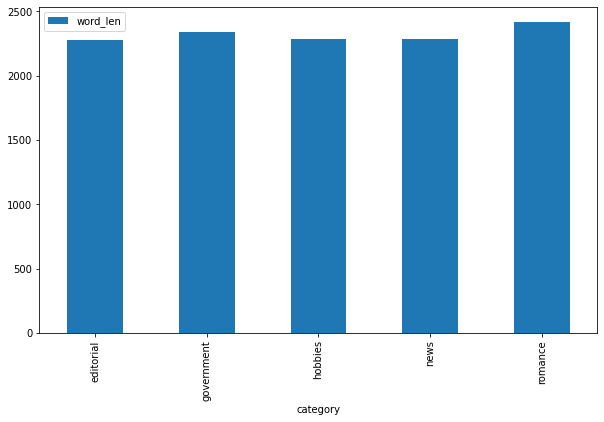

In [12]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [13]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\micha\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [14]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: Both the two data frames hold 166 documents and 4941 unique terms.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [15]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

C:\Users\micha\miniconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [16]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [17]:
doc_topic_df = pd.DataFrame(W_text_matrix)
doc_topic_df['text'] = df['text']
doc_topic_df['category'] = df['category']

# For each topic
for topic in range(W_text_matrix.shape[1]):
    print(f"\nTopic {topic}:")
    # Get the documents
    topic_docs = doc_topic_df[doc_topic_df[topic] > 0.1]
    # Count the frequency
    category_counts = topic_docs['category'].value_counts()
    print(category_counts.head())


Topic 0:
editorial     21
news          13
government     4
Name: category, dtype: int64

Topic 1:
romance      29
editorial     5
hobbies       5
Name: category, dtype: int64

Topic 2:
government    25
hobbies       23
news          14
editorial      6
romance        1
Name: category, dtype: int64

Topic 3:
news         19
romance       1
editorial     1
hobbies       1
Name: category, dtype: int64

Topic 4:
news         10
romance       1
editorial     1
hobbies       1
Name: category, dtype: int64


Q: How does your five-topic NMF model compare to the original Brown categories? 

A:The LSA model appears to agree fairly well with the original Brown corpus categories. This is indicated by the strong overlaps between the LSA topics and the Brown categories.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [18]:
# LSA Model
lsa_text_model = TruncatedSVD(n_components=5, random_state=314)
lsa_text_vectors = lsa_text_model.fit_transform(tfidf_text_vectors)

# Display topic
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())

# Link topics to original categories
topic_category_df_lsa = pd.DataFrame(lsa_text_vectors.argmax(axis=1), columns=['topic'])
topic_category_df_lsa['category'] = df['category']

# Tally 
for topic in range(5):
    print(f"Topic {topic}:")
    print(topic_category_df_lsa[topic_category_df_lsa['topic'] == topic]['category'].value_counts())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)
Topic 0:
hobbies       36
news          34
government    30
editorial     27
romance       21
Name: category, dtype: int64
Topic 1:
romance    8
Name: category, dtype: int64
Topic 2:
Series([], Name: category, dtype: int64)
Topic 3:
news    3
Name: category, dtype: int64
Topic 4:
news    7
Name: category, dtype: int64


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The results of the LSA model and the original Brown categories appear to have some level of agreement, with some variations in each topic.

In [19]:
def display_topics(model, feature_names, no_top_words=5):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [20]:
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())

Topic 0:
said mr mrs state man
Topic 1:
said ll didn thought got
Topic 2:
mrs mr said kennedy khrushchev
Topic 3:
mrs club game jr university
Topic 4:
game league baseball ball team


Q: What is your interpretation of the display topics output? 

A: The display topics output represents the top words associated with five topics identified by the LSA model, reflecting themes related to formal communication, informal dialogue, historical politics, social activities, and sports, possibly specifically baseball. 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [25]:
# CountVectorizer
count_text_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform
count_text_vectors = count_text_vectorizer.fit_transform(df['text'])

# LDA model
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=314)
lda_text_vectors = lda_text_model.fit_transform(count_text_vectors)

# Visualization data
pyLDAvis_data = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer)

# Display topics
pyLDAvis.display(pyLDAvis_data)

C:\Users\micha\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [26]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda_text_model, count_text_vectorizer.get_feature_names(), no_top_words)

Topic 0:
said home year new time good john like just years
Topic 1:
new mrs president united mr states time service american world
Topic 2:
said like just time did man little day know old
Topic 3:
state year new said 000 mr states tax program government
Topic 4:
use used time clay brown af pool long inch new


C:\Users\micha\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The topics from the LDA model appear to cover (Topic 0), politics and government (Topic 1), personal experiences (Topic 2), politics and government again (Topic 3), and maybe crafting (Topic 4). 

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: The five-topic LDA model captures similar themes to the original Brown categories, including politics, personal narratives, and state matters. However, Topic 4 from the model, possibly related to crafting, seems to identify a unique theme not present in the Brown model.

In [29]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [30]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: 
From the principal component scatterplot, it appears that topics 1 and 3 may share some similarities as they are in the same quadrant. This might suggest that some of the vocabulary in these topics overlap or are related in some way. Topics 2 and 4 also share a quadrant, indicating potential overlap as well.

In terms of the salient terms graph, the term 'said' is highly salient across multiple topics, suggesting it's a common term in the corpus but not necessarily informative. 'State' and 'tax' are also important in Topic 0, indicating possible discussion on state matters or policies. The terms 'home', 'year', 'new', 'time' in Topic 1 might suggest narratives revolving around personal or domestic affairs. In Topic 2, 'mrs', 'president', 'united', and 'mr' suggest a political context. Topic 3 seems to revolve around dialogue or narratives due to terms like 'like', 'just', 'time', 'did'. Lastly, Topic 4, with terms like 'state', 'year', 'new', '000', suggests discussions related to years, states or potentially finance or population.
